# Macroscopic titration curve

This notebook analyses the macroscopic titration curve for Epik results of type I, II and III.

In [1]:
from titrato.stats import rmsd_curve, area_between_curves
from titrato.sampl import SAMPL6Experiment, TypeIIIPrediction, TypeIIPrediction, TypeIPrediction, get_typei_pka_data
from titrato import graph_to_axes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.offsetbox import AnchoredText
import matplotlib
import seaborn as sns
from uncertainties import ufloat
import networkx as nx

%matplotlib inline
sns.set_style("ticks")
font = {'size': 24}
matplotlib.rc('font', **font)

titration_data = pd.DataFrame(columns=["Molecule"])

titration_data["Molecule"] = ["SM{:02d}".format(molecule+1) for molecule in range(24)]
# legend:  
#                 [    0 H,     1 H,  2 H ,    3 H,     4 H,      5 H,      6 H,    7 H,      8 H]
color_per_state = ["black", "green", "red", "blue",  "gray", "orange", "purple", "cyan", "yellow"]

## Epik Type I

In [2]:
drop_nodes = dict()
deltas = []

for molecule in range(24):    
    mol_name = "SM{:02d}".format(molecule+1)
    # Plot the results
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    print(mol_name)
    # Load dataset for this molecule
    experimental_curve = SAMPL6Experiment.from_id(mol_name)
    drop = None
    try:
        if mol_name in drop_nodes:
            drop = drop_nodes[mol_name]
        predicted_curve = TypeIPrediction.from_id(mol_name, "Epik/typeI-raw-microscopic.csv", drop_nodes=drop)
    except nx.NetworkXNoPath as e:
        graph, df = get_typei_pka_data(mol_name, "Epik/typeI-raw-microscopic.csv")
        nx.write_graphml(graph, "epik-{}-debug.graphml".format(mol_name))
        print("Could not construct macroscopic curve for {}.".format(mol_name))
        print(e)
        
        continue
    
    # Align the predicted curve to the experimental curve
    predicted_curve.align_mean_charge(experimental_curve, area_between_curves, 0.1)
        
    
    # Shortcuts
    q1 = experimental_curve.mean_charge
    q2 = predicted_curve.mean_charge
    ph = experimental_curve.ph_values
    delta = area_between_curves(q1,q2, 0.1)
    deltas.append(delta)
    # Store the area information in a floating text box in the top right corner
    anchored_text = AnchoredText(r"$\Delta$ = {:.2f}".format(delta), loc=1)
    ax.add_artist(anchored_text)
    
    # Experiment a black solid curve, prediction is green
    ax.plot(ph,q1, color="black", label="Experiment")
    ax.plot(ph,q2, color="green", label="Epik scan")
    
    # Area between curves is colored in gray
    ax.fill_between(ph, q1, q2, facecolor="#dddddd", interpolate=True)
    
    
    # Integer labels for y axis
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)
    ax.set_ylabel("Mean charge")
    ax.set_xlabel("pH")
    ax.set_title(mol_name)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    
    # remove top and right spines
    sns.despine()
    # fit everything within bounds
    plt.tight_layout()
    plt.savefig("Images/Epik/TypeI/{}/charge-curve.png".format(mol_name))
    plt.close(fig)
    # Population curves for experiment
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    for i, state_id in enumerate(experimental_curve.state_ids):
        nbound = experimental_curve.nbound[i]
        color = color_per_state[nbound]
        ax.plot(ph, experimental_curve.populations[i], color=color, label="n={}".format(nbound))
        ax2.plot(ph, experimental_curve.free_energies[i], color=color, label="n={}".format(nbound))
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)    
    ax.set_ylabel("Population")
    ax.set_xlabel("pH")
    #ax.set_title(mol_name)
    
    ax2.set_ylabel(r"Free Energy ($RT$)")
    ax2.set_xlabel("pH")
    #ax2.set_title(mol_name)   
    sns.despine(fig)
    sns.despine(fig2)
    fig.tight_layout()
    fig2.tight_layout()
    fig.savefig("Images/Experiment/{}/population-curve.png".format(mol_name))
    fig2.savefig("Images/Experiment/{}/free-energy-curve.png".format(mol_name))
    
    plt.close(fig)
    plt.close(fig2)
    
    # Population curves for type I
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    for i, state_id in enumerate(predicted_curve.state_ids):
        nbound = predicted_curve.nbound[i]
        color = color_per_state[nbound]
        ax.plot(ph, predicted_curve.populations[i], color=color, label="n={}".format(nbound))
        ax2.plot(ph, predicted_curve.free_energies[i], color=color, label="n={}".format(nbound))
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)    
    ax.set_ylabel("Population")
    ax.set_xlabel("pH")
    ax.set_title(mol_name)
    
    ax2.set_ylabel(r"Free Energy ($RT$)")
    ax2.set_xlabel("pH")
    ax2.set_title(mol_name) 
    sns.despine(fig)
    sns.despine(fig2)
    fig.tight_layout()
    fig2.tight_layout()
    fig.savefig("Images/Epik/TypeI/{}/population-curve.png".format(mol_name))
    fig2.savefig("Images/Epik/TypeI/{}/free-energy-curve.png".format(mol_name))
    plt.close(fig)
    plt.close(fig2)
    
titration_data["Δ Epik Type I"] = deltas

SM01
SM02
SM03
SM04
SM05
SM06
SM07
SM08
SM09
SM10
SM11
SM12
SM13
SM14
SM15
SM16
SM17
SM18
SM19
SM20
SM21
SM22
SM23
SM24


## Type II

In [5]:
deltas = []
for molecule in range(24):    
    mol_name = "SM{:02d}".format(molecule+1)
    print(mol_name)
    # Load dataset for this molecule
    experimental_curve = SAMPL6Experiment.from_id(mol_name)
    predicted_curve = TypeIIPrediction.from_id(mol_name, "Epik/typeII-raw-microscopic.csv", "charges_per_state.csv")
    
    # Align the predicted curve to the experimental curve
    predicted_curve.align_mean_charge(experimental_curve, area_between_curves, 0.1)
    
    # Plot the results
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    
    # Shortcuts
    q1 = experimental_curve.mean_charge
    q2 = predicted_curve.mean_charge
    ph = experimental_curve.ph_values
    
    # Store the area information in a floating text box in the top right corner
    delta = area_between_curves(q1,q2, 0.1)
    deltas.append(delta)
    anchored_text = AnchoredText(r"$\Delta$ = {:.2f}".format(delta), loc=1)
    ax.add_artist(anchored_text)
    
    # Experiment a black solid curve, prediction is green
    ax.plot(ph,q1, color="black", label="Experiment")
    ax.plot(ph,q2, color="green", label="Epik scan")
    
    # Area between curves is colored in gray
    ax.fill_between(ph, q1, q2, facecolor="#dddddd", interpolate=True)
    
    
    # Integer labels for y axis
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)
    ax.set_ylabel("Mean charge")
    ax.set_xlabel("pH")
    ax.set_title(mol_name)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    
    # remove top and right spines
    sns.despine()
    # fit everything within bounds
    plt.tight_layout()
    plt.savefig("Images/Epik/TypeII/{}/charge-curve.png".format(mol_name))
    plt.close(fig)
    
    # Population curves for type II
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    for i, state_id in enumerate(predicted_curve.state_ids):
        nbound = predicted_curve.nbound[i] + abs(min(predicted_curve.nbound))
        color = color_per_state[nbound] 
        ax.plot(ph, predicted_curve.populations[i], color=color, label="n={}".format(nbound))
        ax2.plot(ph, predicted_curve.free_energies[i], color=color, label="n={}".format(nbound))
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)    
    ax.set_ylabel("Population")
    ax.set_xlabel("pH")
    #ax.set_title(mol_name)
    
    ax2.set_ylabel(r"Free Energy ($RT$)")
    ax2.set_xlabel("pH")
    #ax2.set_title(mol_name) 
    sns.despine(fig)
    sns.despine(fig2)
    fig.tight_layout()
    fig2.tight_layout()
    fig.savefig("Images/Epik/TypeII/{}/population-curve.png".format(mol_name))
    fig2.savefig("Images/Epik/TypeII/{}/free-energy-curve.png".format(mol_name))
    plt.close(fig)
    plt.close(fig2)
    

titration_data["Δ Epik Type II"] = deltas

SM01


C:\Users\rustenba\AppData\Local\Continuum\miniconda3\envs\pka-model\lib\site-packages\titrato\titrato.py:260: RuntimeWarning: divide by zero encountered in log
  free_energies = - np.log(populations)
C:\Users\rustenba\AppData\Local\Continuum\miniconda3\envs\pka-model\lib\site-packages\titrato\titrato.py:262: RuntimeWarning: invalid value encountered in subtract
  return free_energies - free_energies[0]


SM02
SM03
SM04
SM05
SM06
SM07
SM08
SM09
SM10
SM11
SM12
SM13
SM14
SM15
SM16
SM17
SM18
SM19
SM20
SM21
SM22
SM23
SM24


## Type III

In [3]:
deltas = []

for molecule in range(24):    
    mol_name = "SM{:02d}".format(molecule+1)
    print(mol_name)
    # Load dataset for this molecule
    experimental_curve = SAMPL6Experiment.from_id(mol_name)
    predicted_curve = TypeIIIPrediction.from_id(mol_name, "Epik/typeIII-raw-sequential.csv")
    
    # Align the predicted curve to the experimental curve
    predicted_curve.align_mean_charge(experimental_curve, area_between_curves, 0.1)
    
    # Plot the results
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    
    # Shortcuts
    q1 = experimental_curve.mean_charge
    q2 = predicted_curve.mean_charge
    ph = experimental_curve.ph_values
    delta = area_between_curves(q1,q2, 0.1)
    deltas.append(delta)
    # Store the area information in a floating text box in the top right corner
    anchored_text = AnchoredText(r"$\Delta$ = {:.2f}".format(delta), loc=1)
    ax.add_artist(anchored_text)
    
    # Experiment a black solid curve, prediction is green
    ax.plot(ph,q1, color="black", label="Experiment")
    ax.plot(ph,q2, color="green", label="Epik scan")
    
    # Area between curves is colored in gray
    ax.fill_between(ph, q1, q2, facecolor="#dddddd", interpolate=True)
    
    
    # Integer labels for y axis
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)
    ax.set_ylabel("Mean charge")
    ax.set_xlabel("pH")
    ax.set_title(mol_name)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    
    # remove top and right spines
    sns.despine()
    # fit everything within bounds
    plt.tight_layout()
    plt.savefig("Images/Epik/TypeIII/{}/charge-curve.png".format(mol_name))
    plt.close(fig)
    
    # Population curves for type II
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    for i, state_id in enumerate(predicted_curve.state_ids):
        nbound = predicted_curve.nbound[i] + abs(min(predicted_curve.nbound))
        color = color_per_state[nbound] 
        ax.plot(ph, predicted_curve.populations[i], color=color, label="n={}".format(nbound))
        ax2.plot(ph, predicted_curve.free_energies[i], color=color, label="n={}".format(nbound))
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)    
    ax.set_ylabel("Population")
    ax.set_xlabel("pH")
    #ax.set_title(mol_name)
    
    ax2.set_ylabel(r"Free Energy ($RT$)")
    ax2.set_xlabel("pH")
    #ax2.set_title(mol_name) 
    sns.despine(fig)
    sns.despine(fig2)
    fig.tight_layout()
    fig2.tight_layout()
    fig.savefig("Images/Epik/TypeIII/{}/population-curve.png".format(mol_name))
    fig2.savefig("Images/Epik/TypeIII/{}/free-energy-curve.png".format(mol_name))
    plt.close(fig)
    plt.close(fig2)
    
    
titration_data["Δ Epik Type III"] = deltas

SM01
SM02


C:\Users\rustenba\AppData\Local\Continuum\miniconda3\envs\pka-model\lib\site-packages\titrato\titrato.py:260: RuntimeWarning: invalid value encountered in log
  free_energies = - np.log(populations)


SM03
SM04
SM05
SM06
SM07
SM08
SM09
SM10
SM11
SM12
SM13
SM14
SM15
SM16
SM17
SM18
SM19
SM20
SM21
SM22
SM23
SM24


## Jaguar type I

In [5]:
deltas = []

for molecule in range(24):    
    mol_name = "SM{:02d}".format(molecule+1)
    # Plot the results
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    print(mol_name)
    # Load dataset for this molecule
    experimental_curve = SAMPL6Experiment.from_id(mol_name)
    drop = None
    try:
        if mol_name in drop_nodes:
            drop = drop_nodes[mol_name]
        predicted_curve = TypeIPrediction.from_id(mol_name, "Jaguar/typeI-raw.csv", drop_nodes=drop)
    except nx.NetworkXNoPath as e:
        graph, df = get_typei_pka_data(mol_name, "Jaguar/typeI-raw.csv")
        nx.write_graphml(graph, "{}-debug.graphml".format(mol_name))
        print("Could not construct macroscopic curve for {}.".format(mol_name))
        deltas.append(np.nan)
        print(e)
        
        continue
    
    # Align the predicted curve to the experimental curve
    predicted_curve.align_mean_charge(experimental_curve, area_between_curves, 0.1)
        
    
    # Shortcuts
    q1 = experimental_curve.mean_charge
    q2 = predicted_curve.mean_charge
    ph = experimental_curve.ph_values
    delta = area_between_curves(q1,q2, 0.1)
    deltas.append(delta)
    # Store the area information in a floating text box in the top right corner
    anchored_text = AnchoredText(r"$\Delta$ = {:.2f}".format(delta), loc=1)
    ax.add_artist(anchored_text)
    
    # Experiment a black solid curve, prediction is green
    ax.plot(ph,q1, color="black", label="Experiment")
    ax.plot(ph,q2, color="green", label="Epik scan")
    
    # Area between curves is colored in gray
    ax.fill_between(ph, q1, q2, facecolor="#dddddd", interpolate=True)
    
    
    # Integer labels for y axis
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)
    ax.set_ylabel("Mean charge")
    ax.set_xlabel("pH")
    ax.set_title(mol_name)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    
    # remove top and right spines
    sns.despine()
    # fit everything within bounds
    plt.tight_layout()
    plt.savefig("Images/Jaguar/TypeI/{}/charge-curve.png".format(mol_name))
    plt.close(fig)
    
    # Population curves for type II
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    plt.xticks(np.arange(2.0, 14.0, 2.0))
    for i, state_id in enumerate(predicted_curve.state_ids):
        nbound = predicted_curve.nbound[i] + abs(min(predicted_curve.nbound))
        color = color_per_state[nbound] 
        ax.plot(ph, predicted_curve.populations[i], color=color, label="n={}".format(nbound))
        ax2.plot(ph, predicted_curve.free_energies[i], color=color, label="n={}".format(nbound))
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))    
    labels = [item.get_text() for item in ax.get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_yticklabels(empty_string_labels)    
    ax.set_ylabel("Population")
    ax.set_xlabel("pH")
    ax.set_title(mol_name)
    
    ax2.set_ylabel(r"Free Energy ($RT$)")
    ax2.set_xlabel("pH")
    ax2.set_title(mol_name) 
    sns.despine(fig)
    sns.despine(fig2)
    fig.tight_layout()
    fig2.tight_layout()
    fig.savefig("Images/Jaguar/TypeI/{}/population-curve.png".format(mol_name))
    fig2.savefig("Images/Jaguar/TypeI/{}/free-energy-curve.png".format(mol_name))
    plt.close(fig)
    plt.close(fig2)
    
    

titration_data["Δ Jaguar Type I"] = deltas

SM01
SM02
SM03
SM04
SM05
SM06
SM07
SM08
SM09
SM10
SM11
SM12
SM13
SM14
SM15
SM16
SM17
SM18
SM19
SM20
SM21
SM22
SM23
SM24


In [8]:
print(titration_data.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Molecule &  Δ Epik Type I &  Δ Epik Type II &  Δ Epik Type III &  Δ Jaguar Type I \\
\midrule
    SM01 &       0.435062 &        0.446500 &         0.463591 &         0.151006 \\
    SM02 &       2.121594 &        0.594315 &         1.997597 &         1.213176 \\
    SM03 &       0.107522 &        0.290227 &         0.099998 &         0.576302 \\
    SM04 &       2.555586 &        0.269335 &         2.203341 &         0.810513 \\
    SM05 &       1.931912 &        0.746949 &         1.081600 &         0.358297 \\
    SM06 &       2.916909 &        2.527597 &         2.626087 &         2.099515 \\
    SM07 &       2.615578 &        0.329331 &         2.256232 &         0.845060 \\
    SM08 &       2.133806 &        0.573687 &         0.631704 &         6.567410 \\
    SM09 &       2.531652 &        0.789920 &         2.320220 &         1.099839 \\
    SM10 &       0.174557 &        0.348154 &         0.624909 &         0.282818 \\
    SM11 &       1.84341

In [9]:
titration_data = titration_data.append(titration_data.mean(), ignore_index=True)

In [10]:
print(titration_data.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Molecule &  Δ Epik Type I &  Δ Epik Type II &  Δ Epik Type III &  Δ Jaguar Type I \\
\midrule
    SM01 &       0.435062 &        0.446500 &         0.463591 &         0.151006 \\
    SM02 &       2.121594 &        0.594315 &         1.997597 &         1.213176 \\
    SM03 &       0.107522 &        0.290227 &         0.099998 &         0.576302 \\
    SM04 &       2.555586 &        0.269335 &         2.203341 &         0.810513 \\
    SM05 &       1.931912 &        0.746949 &         1.081600 &         0.358297 \\
    SM06 &       2.916909 &        2.527597 &         2.626087 &         2.099515 \\
    SM07 &       2.615578 &        0.329331 &         2.256232 &         0.845060 \\
    SM08 &       2.133806 &        0.573687 &         0.631704 &         6.567410 \\
    SM09 &       2.531652 &        0.789920 &         2.320220 &         1.099839 \\
    SM10 &       0.174557 &        0.348154 &         0.624909 &         0.282818 \\
    SM11 &       1.84341

(0, 1)

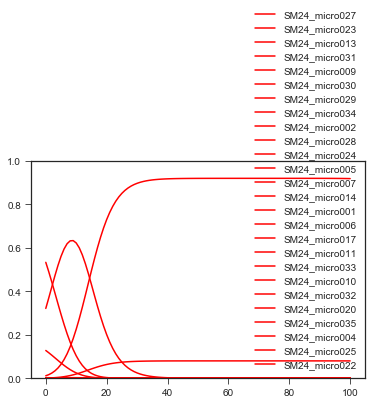

In [18]:
for i, state in enumerate(predicted_curve.state_ids):
    plt.plot(predicted_curve.populations[i], label=state, color="red")
plt.legend()
plt.ylim([0,1
        ])


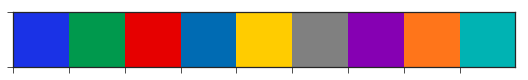

In [98]:
#                 [    0 H,         1 H,      2 H ,       3 H,       4 H,     5 H,      6 H,    7 H,      8 H]
color_per_state = ["#1a32e6", "#00994d", "#e60000", "#006bb3", "#ffcc00",  "#808080", "#8600b3", "#ff751a",  "#00b3b3"]
sns.palplot(sns.color_palette(color_per_state))

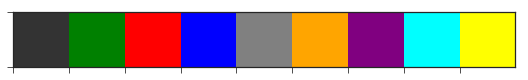

In [91]:
y = int("00994d",16)
z = int("333333", 16)

In [97]:
hex(round(y + z / 2))

'0x1a32e6'

In [5]:
from titrato.plots import plot_free_energy, plot_experimental_free_energy
from matplotlib import pyplot as plt

(<matplotlib.axes._subplots.AxesSubplot at 0x5ca458ca58>,
 <Figure size 750x750 with 1 Axes>)

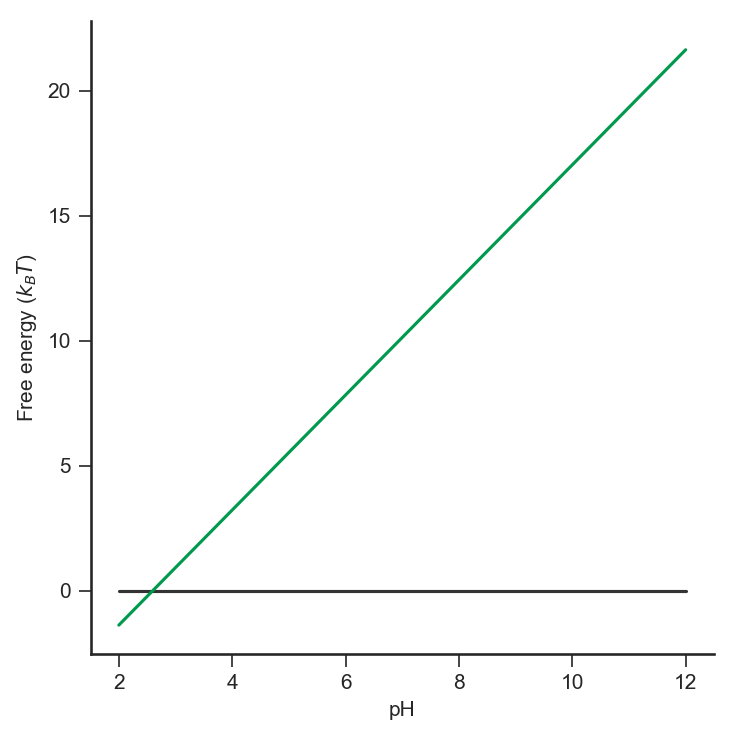

In [18]:
plot_experimental_free_energy("SM24", include_experiment=False, closefig=False)

In [17]:
x = plt.gcf()

<Figure size 432x288 with 0 Axes>

In [14]:
plt.show(x)

In [15]:
% matplotlib inline

In [16]:
plt.show(x)